In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/Users/danielturcza/anaconda/envs/PythonData/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [5]:
crimes = pd.read_csv("data/out/enriched_cta_crime_data.csv", index_col=0)
cta = pd.read_csv("data/out/enriched_cta_data.csv", index_col=0)

/Users/danielturcza/anaconda/envs/PythonData/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [13]:
from datetime import datetime
import time

In [14]:
print(time.strptime.__doc__)

strptime(string, format) -> struct_time

Parse a string to a time tuple according to a format specification.
See the library reference manual for formatting codes (same as
strftime()).

Commonly used format codes:

%Y  Year with century as a decimal number.
%m  Month as a decimal number [01,12].
%d  Day of the month as a decimal number [01,31].
%H  Hour (24-hour clock) as a decimal number [00,23].
%M  Minute as a decimal number [00,59].
%S  Second as a decimal number [00,61].
%z  Time zone offset from UTC.
%a  Locale's abbreviated weekday name.
%A  Locale's full weekday name.
%b  Locale's abbreviated month name.
%B  Locale's full month name.
%c  Locale's appropriate date and time representation.
%I  Hour (12-hour clock) as a decimal number [01,12].
%p  Locale's equivalent of either AM or PM.

Other codes may be available on your platform.  See documentation for
the C library strftime function.



In [17]:
crimes["date_obj"] = crimes["date"].map(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S"))

In [26]:
crimes["date_only"] = crimes["date_obj"].map(lambda x: x.date())

In [31]:
cta["date_obj"] = cta["date"].map(lambda x: datetime.strptime(x, "%m/%d/%Y"))

In [44]:
crimes["month"] = crimes["date_only"].map(lambda x: x.month)

In [45]:
cta["month"] = cta["date_obj"].map(lambda x: x.month)

In [150]:
def cpm(column, selectors=None):
    if selectors:
        selectors = selectors + [column]
    else:
        selectors = [column]
    return 1000000 * crimes.fillna(0).groupby(selectors)["crimes_split"].sum() / cta.fillna(0).groupby(selectors)["rides_split"].sum()

In [51]:
cta.rename({"date_obj": "date_only"}, axis="columns", inplace=True)

In [53]:
cta["year"] = cta["date_only"].map(lambda x: x.year)
crimes["year"] = crimes["date_only"].map(lambda x: x.year)

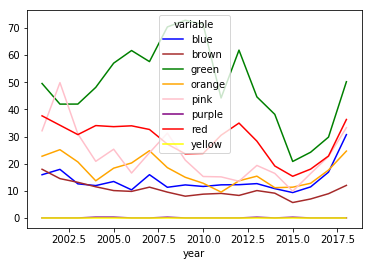

In [85]:
plot_data = cpm("year", ["variable"]).unstack().fillna(0).transpose()
plot_data.plot(kind="line", color=plot_data.columns)

In [86]:
crimes.head()

id    station_name fbi_code                 date  map_id  \
3   10398565  Clark/Division       06  2016-01-26T17:15:00   40630   
11  10003296            79th       06  2015-03-21T00:49:00   40240   
13  10003791          Howard       26  2015-03-21T18:30:00   40900   
17  10005846  Clark/Division       26  2015-03-23T19:20:00   40630   
18  10005931         Chicago       03  2015-03-23T20:11:00   41450   

             updated_on case_number                  description  year  \
3   2018-02-10T15:50:01    HZ132929               POCKET-PICKING  2016   
11  2018-02-10T15:50:01    HY192777               POCKET-PICKING  2015   
13  2018-02-10T15:50:01    HY193540  VIOLATE ORDER OF PROTECTION  2015   
17  2018-02-10T15:50:01    HY195928            TO STATE SUP LAND  2015   
18  2018-02-10T15:50:01    HY195940        STRONGARM - NO WEAPON  2015   

     latitude  ...    closest_stop_id  district community_area arrest  \
3   41.904370  ...              30122        18            8.0  False   
11  41.750941  ...              30046         6           44.0  False   
13  42.019373  ...              30173        24            1.0   True   
17  41.904370  ...              30122        18            8.0   True   
18  41.899340  ...              30279        18            8.0  False   

   crimes_split  longitude variable            date_obj   date_only  month  
3           1.0 -87.631460      red 2016-01-26 17:15:00  2016-01-26      1  
11          1.0 -87.625185      red 2015-03-21 00:49:00  2015-03-21      3  
13          1.0 -87.670888      red 2015-03-21 18:30:00  2015-03-21      3  
17          1.0 -87.631460      red 2015-03-23 19:20:00  2015-03-23      3  
18          1.0 -87.628272      red 2015-03-23 20:11:00  2015-03-23      3  

[5 rows x 31 columns]

In [89]:
cta.groupby(["year"])["rides_split"].sum()

year
2001    1.466204e+08
2002    1.473467e+08
2003    1.452662e+08
2004    1.428528e+08
2005    1.488319e+08
2006    1.563623e+08
2007    1.540562e+08
2008    1.613133e+08
2009    1.633997e+08
2010    1.696625e+08
2011    1.800477e+08
2012    1.856097e+08
2013    1.823806e+08
2014    1.904562e+08
2015    1.946706e+08
2016    1.925489e+08
2017    1.866775e+08
2018    1.391535e+08
Name: rides_split, dtype: float64

In [95]:
crimes_by_type = crimes.groupby(["year", "description"])["crimes_split"].sum().unstack().fillna(0)

In [96]:
cta_by_type = cta.groupby(["year"])["rides_split"].sum()

In [106]:
crimes_by_type.loc[2001].name

2001

In [138]:
# adjust for the fact that we only have months 1-9 in 2018
cta_by_type.loc[2018] = cta_by_type.loc[2018] * 1.333

In [139]:
crimes_by_type["ridership"] = cta_by_type

In [123]:
crimes_of_interest = ['POCKET-PICKING', '$500 AND UNDER', 'SIMPLE', 'OVER $500',
       'CREDIT CARD FRAUD', 'STRONGARM - NO WEAPON']

In [140]:
crimes_by_type.apply(lambda x: 1000000 * x / x['ridership'], axis=1).sort_values(by=2018, axis=1, ascending=False)[crimes_of_interest].plot(kind="line")

In [143]:
crimes.columns

Index(['id', 'station_name', 'fbi_code', 'date', 'map_id', 'updated_on',
       'case_number', 'description', 'year', 'latitude', 'line_count', 'ada',
       'iucr', 'block', 'primary_type', 'domestic', 'location_description',
       'ward', 'beat', 'y_coordinate', 'x_coordinate', 'closest_stop_id',
       'district', 'community_area', 'arrest', 'crimes_split', 'longitude',
       'variable', 'date_obj', 'date_only', 'month'],
      dtype='object')

In [146]:
cta.rename({"stationname": "station_name"}, axis="columns", inplace=True)

In [156]:
cta.rename({"station_id": "map_id"}, axis="columns", inplace=True)

What are the looks we're going to put in here?

Crime on the CTA is up for the 3rd year in a row and 

In [187]:
cta_adj = cta.groupby("year")["rides_split"].sum()
cta_adj.loc[2018] = cta_adj.loc[2018] * 1.333

### Crime on the CTA has roughly doubled in the last 3 years

In [191]:
(1000000 * crimes.groupby("year")["crimes_split"].sum() / cta_adj).plot(kind="line")
plt.ylim(bottom=0)

(0, 28.825258715304876)

### This is largely driven by pocket-picking

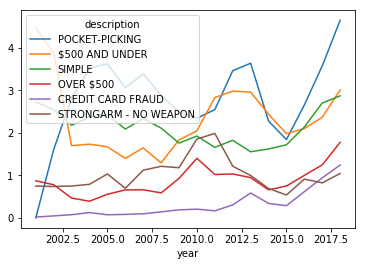

In [192]:
crimes_by_type.apply(lambda x: 1000000 * x / x['ridership'], axis=1).sort_values(by=2018, axis=1, ascending=False)[crimes_of_interest].plot(kind="line")

In [216]:
community_areas = pd.read_csv("data/community_areas.csv", index_col=0)

In [214]:
print(community_areas.merge.__doc__)


Merge DataFrame objects by performing a database-style join operation by
columns or indexes.

If joining columns on columns, the DataFrame indexes *will be
ignored*. Otherwise if joining indexes on indexes or indexes on a column or
columns, the index will be passed on.

Parameters
----------
right : DataFrame
how : {'left', 'right', 'outer', 'inner'}, default 'inner'
    * left: use only keys from left frame, similar to a SQL left outer join;
      preserve key order
    * right: use only keys from right frame, similar to a SQL right outer join;
      preserve key order
    * outer: use union of keys from both frames, similar to a SQL full outer
      join; sort keys lexicographically
    * inner: use intersection of keys from both frames, similar to a SQL inner
      join; preserve the order of the left keys
on : label or list
    Field names to join on. Must be found in both DataFrames. If on is
    None and not merging on indexes, then it merges on the intersection of
    the colum

In [220]:
crimes["area_name"] = crimes[["community_area"]].merge(community_areas, how="left", left_on="community_area", right_index=True)["area_name"]

In [222]:
crimes_by_area_year = (1000000 * crimes.groupby(["year","area_name"])["crimes_split"].sum()).unstack().apply(lambda x: x / cta_adj[x.name], axis=1).fillna(0).sort_values(2018, axis=1, ascending=False)
crimes_by_area_year

area_name      LOOP  NEAR NORTH SIDE  ROGERS PARK  WEST TOWN  NEAR WEST SIDE  \
year                                                                           
2002       4.316351         1.893494     0.712605   0.529364        0.658311   
2003       5.796256         2.127130     0.722811   0.378615        1.005051   
2004       4.256128         1.939058     1.029031   0.483015        0.798024   
2005       4.992211         1.760376     1.081758   0.483767        0.812998   
2006       4.483176         1.726758     1.323848   0.300584        0.626749   
2007       5.712201         1.986288     1.324192   0.467362        0.863321   
2008       5.151466         1.617970     0.998058   0.229367        0.805885   
2009       3.800497         1.689110     0.832315   0.232559        0.740515   
2010       3.854712         1.632653     0.719075   0.200398        0.689604   
2011       3.982279         3.410208     0.516530   0.233272        0.733139   
2012       4.746519         2.968595     0.614192   0.237057        0.673456   
2013       4.868938         2.132902     0.789558   0.444126        0.822456   
2014       3.712139         1.338890     0.504053   0.304532        0.682572   
2015       2.455430         0.842449     0.667795   0.231160        0.554783   
2016       3.588698         1.095825     0.737475   0.306416        0.534929   
2017       5.153272         1.864177     1.033868   0.642820        0.733886   
2018       6.501639         1.897659     1.326205   0.959612        0.954221   

area_name  WEST GARFIELD PARK  ROSELAND  LAKE VIEW   CHATHAM    AUSTIN  \
year                                                                     
2002                 0.285042  0.732965   1.011221  0.631165  0.692245   
2003                 0.316660  0.874257   1.307944  0.977516  0.736579   
2004                 0.574017  1.351041   1.085033  1.281039  0.791024   
2005                 0.900345  1.135510   0.954097  1.095196  1.363955   
2006                 1.438965  1.458152   0.863379  0.984892  1.713968   
2007                 1.415068  1.298228   0.804901  0.876304  1.415068   
2008                 1.822540  1.066248   0.700500  0.781089  1.450593   
2009                 2.093027  0.826195   0.771115  0.593636  1.425951   
2010                 1.921462  0.660134   0.742651  0.831062  1.561925   
2011                 1.321872  0.649828   0.666490  0.616503  0.849775   
2012                 2.327465  0.668069   0.765046  0.948226  0.797372   
2013                 1.738123  0.542821   0.816973  0.822456  0.537338   
2014                 1.008106  0.588062   0.677321  0.462048  0.593312   
2015                 0.359582  0.616426   0.498278  0.529099  0.416088   
2016                 0.488188  0.597251   0.592057  0.602444  0.410285   
2017                 0.583895  0.755313   0.653533  0.669604  0.380335   
2018                 0.938047  0.911092   0.824835  0.749360  0.711622   

area_name    ...     RIVERDALE   PULLMAN  CALUMET HEIGHTS   OAKLAND  \
year         ...                                                      
2002         ...      0.000000  0.006787         0.000000  0.000000   
2003         ...      0.000000  0.006884         0.000000  0.000000   
2004         ...      0.000000  0.000000         0.000000  0.000000   
2005         ...      0.000000  0.006719         0.000000  0.000000   
2006         ...      0.000000  0.000000         0.012791  0.000000   
2007         ...      0.000000  0.000000         0.000000  0.000000   
2008         ...      0.006199  0.000000         0.000000  0.000000   
2009         ...      0.000000  0.000000         0.006120  0.000000   
2010         ...      0.000000  0.000000         0.000000  0.000000   
2011         ...      0.000000  0.000000         0.000000  0.005554   
2012         ...      0.005388  0.000000         0.000000  0.000000   
2013         ...      0.000000  0.000000         0.000000  0.000000   
2014         ...      0.000000  0.000000         0.000000  0.000000   
2015   

### The Loop is seeing the largest increase in crime from 2015.

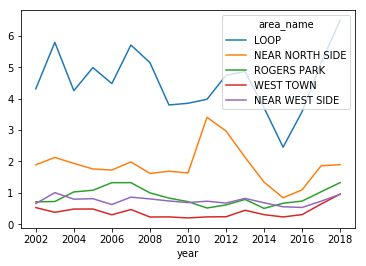

In [226]:
areas_of_interest = crimes_by_area_year[crimes_by_area_year.columns[:5]].plot(kind="line")

Despite the apparent difference in the chart, crime growth from 2015 as a percentage is much more similar across areas. However, since the Loop already represents a large area with a plurality of crimes, it still drives most of the overall increase.

In [239]:
import numpy as np

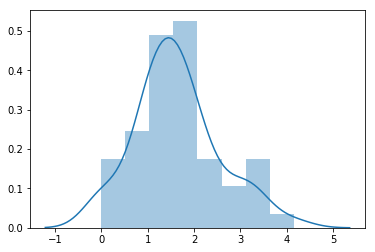

In [241]:
crime_increase_area = (crimes_by_area_year.loc[2018] / crimes_by_area_year.loc[2015]).dropna()
crime_increase_area = crime_increase_area[crime_increase_area != np.float("inf")]
sns.distplot(crime_increase_area)

In [244]:
(crimes_by_area_year.loc[2018] / crimes_by_area_year.loc[2015]).dropna().sort_values()

area_name
DUNNING                   0.000000
ASHBURN                   0.000000
WEST RIDGE                0.000000
BELMONT CRAGIN            0.000000
ARCHER HEIGHTS            0.349828
BRIDGEPORT                0.667854
NEAR SOUTH SIDE           0.824595
GREATER GRAND CROSSING    0.855558
AVONDALE                  0.918299
ALBANY PARK               0.940917
JEFFERSON PARK            0.951858
UPTOWN                    0.998703
CLEARING                  1.049484
WEST LAWN                 1.049484
WEST ELSDON               1.076394
GARFIELD RIDGE            1.084467
WEST ENGLEWOOD            1.117193
WOODLAWN                  1.136941
ARMOUR SQUARE             1.246262
WASHINGTON PARK           1.249386
EDGEWATER                 1.319351
IRVING PARK               1.372402
ENGLEWOOD                 1.407845
CHATHAM                   1.416294
ROSELAND                  1.478023
DOUGLAS                   1.533861
AUBURN GRESHAM            1.574226
BRIGHTON PARK             1.574226
PORTAGE PA

In [266]:
cta_line_adj = cta.groupby(["year", "variable"])["rides_split"].sum()

In [269]:
cta_line_adj.loc[2018, :] = cta_line_adj.loc[2018, :] * 1.333

In [270]:
cta_line_adj

year  variable
2001  blue        3.386541e+07
      brown       2.072044e+07
      green       1.168378e+07
      orange      1.184586e+07
      pink        6.799123e+06
      purple      3.721133e+06
      red         5.664414e+07
      yellow      1.340514e+06
2002  blue        3.419850e+07
      brown       2.061362e+07
      green       1.164657e+07
      orange      1.186950e+07
      pink        6.487685e+06
      purple      3.691313e+06
      red         5.754893e+07
      yellow      1.290552e+06
2003  blue        3.425402e+07
      brown       2.049722e+07
      green       1.142480e+07
      orange      1.179073e+07
      pink        6.081805e+06
      purple      3.725025e+06
      red         5.624450e+07
      yellow      1.248086e+06
2004  blue        3.472225e+07
      brown       1.999848e+07
      green       1.117730e+07
      orange      1.168161e+07
      pink        6.227071e+06
      purple      3.640151e+06
                      ...     
2015  green       1.6006

/Users/danielturcza/anaconda/envs/PythonData/lib/python3.6/site-packages/pandas/core/indexes/multi.py:860: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_value(s, k)


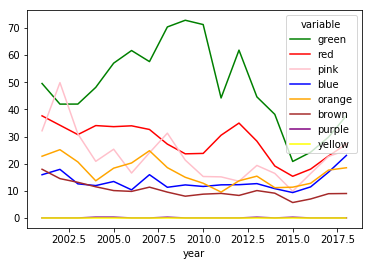

In [273]:
crimes_by_line_year = (1000000 * crimes.groupby(["year","variable"])["crimes_split"].sum()).unstack().apply(lambda x: x / cta_line_adj[x.name], axis=1).fillna(0).sort_values(2018, axis=1, ascending=False)
crimes_by_line_year.fillna(0).plot(kind="line", color=crimes_by_line_year.columns)

In [274]:
crimes_by_line_year.loc[2018] / crimes_by_line_year.loc[2015]

variable
green     1.810040
red       1.773539
pink      2.535533
blue      2.465160
orange    1.631213
brown     1.586626
purple    0.000000
yellow         NaN
dtype: float64

An interesting look might be what the percentage increases are by line once you take out crime on the loop

In [279]:
crimes_by_beat_year = (1000000 * crimes.groupby(["year","beat"])["crimes_split"].sum()).unstack().apply(lambda x: x / cta_adj[x.name], axis=1).fillna(0).sort_values(2018, axis=1, ascending=False)
crimes_by_beat_year

beat      122       112       113       2422      123       111       623   \
year                                                                         
2001  2.653110  0.225071  1.807388  0.313735  1.132175  0.054563  2.080202   
2002  2.008868  0.217175  1.893494  0.604018  0.895846  0.027147  0.848339   
2003  1.734746  0.296008  1.528229  0.413035  0.915561  0.027536  0.915561   
2004  1.148035  0.140004  1.015031  0.588018  0.945029  0.049001  1.099033   
2005  1.397550  0.235165  1.021287  0.638304  1.007849  0.047033  0.860031   
2006  0.908147  0.185467  0.684308  0.626749  1.119195  0.044768  0.729076   
2007  0.714025  0.389468  0.980162  0.610167  1.830501  0.064911  0.662096   
2008  0.700500  0.272761  1.339009  0.533124  1.462992  0.099186  0.663306   
2009  0.642596  0.312118  0.979194  0.507957  0.875155  0.116279  0.471237   
2010  0.630664  0.418478  0.577617  0.306491  1.143447  0.053046  0.589406   
2011  0.449881  0.311029  0.533192  0.311029  1.227453  0.055541  0.405448   
2012  0.721945  0.457950  1.600132  0.360973  1.018266  0.624967  0.738108   
2013  1.228201  0.498956  1.134989  0.526372  1.085642  0.893735  0.696346   
2014  0.829587  0.388541  1.144620  0.315033  0.577561  0.761330  0.357037   
2015  0.698616  0.349308  0.601015  0.503415  0.416088  0.364719  0.380129   
2016  0.877699  0.477801  0.877699  0.482994  0.732281  0.602444  0.436253   
2017  1.301710  0.894591  1.264212  0.841023  0.824952  0.857093  0.498185   
2018  1.924615  1.531066  1.121344  1.045869  0.970394  0.932656  0.587627   

beat      511       1132      1832    ...         1624      1632      1031  \
year                                  ...                                    
2001  0.197790  0.136407  0.538806    ...     0.000000  0.000000  0.000000   
2002  0.230748  0.088227  1.425210    ...     0.006787  0.000000  0.000000   
2003  0.172098  0.082607  1.018819    ...     0.006884  0.000000  0.000000   
2004  0.224007  0.175005  0.749023    ...     0.000000  0.000000  0.007000   
2005  0.167975  0.376264  0.671899    ...     0.000000  0.000000  0.000000   
2006  0.140699  0.140699  0.888961    ...     0.000000  0.000000  0.000000   
2007  0.272628  0.337539  1.097002    ...     0.000000  0.006491  0.000000   
2008  0.223168  0.229367  0.849279    ...     0.000000  0.000000  0.000000   
2009  0.214199  0.361078  0.887395    ...     0.006120  0.000000  0.000000   
2010  0.170928  0.406690  0.707287    ...     0.005894  0.000000  0.000000   
2011  0.155514  0.399894  2.104998    ...     0.000000  0.000000  0.000000   
2012  0.123916  0.371748  1.853351    ...     0.000000  0.000000  0.005388   
2013  0.115144  0.268669  1.052743    ...     0.000000  0.000000  0.000000   
2014  0.168018  0.210022  0.540807    ...     0.000000  0.000000  0.000000   
2015  0.195202  0.133559  0.282529    ...     0.005137  0.000000  0.000000   
2016  0.197352  0.285642  0.358350    ...     0.005193  0.000000  0.000000   
2017  0.326767  0.449974  0.599965    ...     0.000000  0.000000  0.000000   
2018  0.566063  0.560672  0.539108    ...     0.000000  0.000000  0.000000   

beat      1633      1634      1033      1652      1032      314       2535  
year                                                                        
2001  0.006820  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2002  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2003  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2004  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2005  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.006719  
2006  0.012791  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2007  0.000000  0.000000  0.000000  0.000000  0.006491  0.000000  0.000000  
2008  0.000000  0.000000  0.000000  0.000000  0.000000  0.006199  0.000000  
2009  0.000000  0.000000  0.000000  0.000000  0.000000  0.006120  0.000000  
2010  0.000000  0.000000  0.000

In [288]:
crimes_by_beat_year.loc[2018].sum()

22.626351496484094

In [290]:
crimes_by_beat_year.loc[2018].iloc[:45].sum()

18.405137957826227

15% of the beats contain 80% of the CTA crime. Probably this isn't surprising.

In [292]:
crimes.columns

Index(['id', 'station_name', 'fbi_code', 'date', 'map_id', 'updated_on',
       'case_number', 'description', 'year', 'latitude', 'line_count', 'ada',
       'iucr', 'block', 'primary_type', 'domestic', 'location_description',
       'ward', 'beat', 'y_coordinate', 'x_coordinate', 'closest_stop_id',
       'district', 'community_area', 'arrest', 'crimes_split', 'longitude',
       'variable', 'date_obj', 'date_only', 'month', 'area_name'],
      dtype='object')

How would we show that crimes cluster?

The idea is that if a crime is reported at a station, does that increase the likelihood that more crimes will be reported within a short period of time? How short? Can you use it to predict whether another crime will likely happen soon?
```
x      x       x       x
x x          x x     
```
I think the question is basically how much standard deviation there is in the amount of time until the next crime at that station. In the top scenario, there is not much variance, whereas there is a lot of variation in the bottom one.

In [323]:
test_crimes = crimes.loc[crimes.station_name == "Howard"].sort_values("date_obj")
# test_crimes
time_between_crimes = (test_crimes["date_obj"].iloc[1:] - test_crimes["date_obj"].iloc[:-1].values)

In [324]:
time_between_crimes.mean()

Timedelta('4 days 05:59:13.831168')

In [337]:
np.std(time_between_crimes)

Timedelta('4 days 19:01:32.556460')

In [341]:
np.std(time_between_crimes) / time_between_crimes.mean()

1.1278448467841422

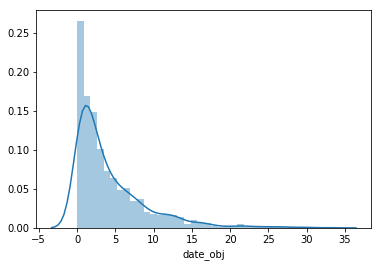

In [340]:
sns.distplot(time_between_crimes.map(lambda x: x.total_seconds() / (60 * 60 * 24)))

In [342]:
def coef_determination(station_data):
    station_data = station_data.sort_values("date_obj")
    time_between_crimes = (station_data["date_obj"].iloc[1:] - station_data["date_obj"].iloc[:-1].values)
    return np.std(time_between_crimes) / time_between_crimes.mean()

In [345]:
crimes.groupby("station_name").apply(coef_determination).sort_values(ascending=False)

station_name
Morgan                                       3.127424
Adams/Wabash                                 2.645407
Clark/Lake                                   2.642672
Conservatory                                 2.351174
Washington/Wells                             2.165334
State/Lake                                   2.063309
Washington/Wabash                            2.052592
Quincy/Wells                                 1.862094
18th                                         1.803983
Wilson                                       1.794522
Kostner                                      1.772321
Ashland                                      1.743149
Lake                                         1.668266
Morse                                        1.617470
Harrison                                     1.593902
Laramie                                      1.546866
Paulina                                      1.537761
Roosevelt                                    1.537410
Sox-35th       

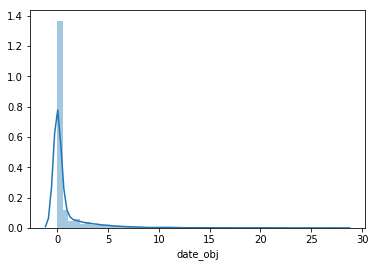

In [349]:
station = crimes.loc[crimes.station_name == "Clark/Lake"]
station_data = station.sort_values("date_obj")
time_between_station = (station_data["date_obj"].iloc[1:] - station_data["date_obj"].iloc[:-1].values)
sns.distplot(time_between_station.map(lambda x: x.total_seconds() / (60 * 60 * 24)))

In [350]:
station.shape

(7581, 32)

Lots of evidence of clustering, but is it useful? It may just track with the extent to which these things overlap with commuting patterns.

In [356]:
crimes.hour = crimes["date_obj"].map(lambda x: x.hour)

/Users/danielturcza/anaconda/envs/PythonData/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':


In [357]:
sns.distplot(crimes.hour)

In [360]:
crimes.day_of_week = crimes['date_obj'].map(lambda x: x.weekday())

/Users/danielturcza/anaconda/envs/PythonData/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':


In [361]:
sns.distplot(crimes.day_of_week)